In [228]:
!jupyter nbconvert olist_presentation.ipynb --to slides --post serve \
--no-prompt \
--TagRemovePreprocessor.remove_input_tags=remove_input \
--TagRemovePreprocessor.remove_all_outputs_tags=remove_output

[NbConvertApp] Converting notebook olist_presentation.ipynb to slides
[NbConvertApp] Writing 829700 bytes to olist_presentation.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/olist_presentation.slides.html
Use Control-C to stop this server
^C

Interrupted


# Olist Seller Analysis

## Background
Olist is a Brazillian e-commerce company that helps small businesses sell goods to customers. 📭  
The customers can then leave reviews for their orders from the sellers. ⭐️  
Due to poor reviews (and some other factors), some sellers end up costing Olist quite a bit of money. 👎  
How can olist minimize these costs❓  

*️⃣ This analysis used the [public Olist dataset](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce), which contains data for 100k+ orders from 2016-2018

In [180]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
from olist.seller import Seller
from olist.data import Olist
from olist.order import Order

data = Olist().get_data()
sellers = Seller().get_training_data()
orders = Order().get_training_data(with_distance_seller_customer=True).copy()

## Olist should remove the worst performing sellers from its platform 😲

In [4]:
seller_profits = sellers.copy()

# revenue from commission
seller_profits['revenue_commission'] = (sellers['sales'] * 0.1) 

# revenue from subscriptions
seller_profits['revenue_subscription'] = sellers['months_on_olist'] * 80

# cost per seller
review_scores = data['order_reviews'][['order_id','review_score']].merge(data['orders'][['order_id']], on='order_id').merge(data['order_items'][['order_id', 'seller_id']], on='order_id')
review_scores['cost_per_review'] = review_scores.review_score.map({1: 100, 2: 50, 3: 40, 4: 0, 5: 0})
review_scores = review_scores[['seller_id', 'cost_per_review']].groupby('seller_id').cost_per_review.sum()
seller_profits = seller_profits.merge(review_scores, on='seller_id')

# profit per seller - revenue - cost
seller_profits['profit'] = seller_profits['revenue_commission'] + seller_profits['revenue_subscription'] - seller_profits['cost_per_review']

In [5]:
sorted_sellers = seller_profits.sort_values('profit', ascending=False, ignore_index=True)

# cumulative profit before and after it costs
sorted_sellers['cum_profit'] = sorted_sellers.profit.cumsum()
sorted_sellers['cum_it_costs'] = (sorted_sellers.n_orders.cumsum() ** 0.5) * it_costs_coef
# sorted_sellers['cum_it_costs_by_seller'] = sorted_sellers.cum_it_costs - sorted_sellers.cum_it_costs.shift(1, fill_value=0)
sorted_sellers['profit_after_it_costs'] = sorted_sellers['cum_profit'] - sorted_sellers['cum_it_costs']

In [6]:
# IT costs per seller - it_costs = coef * total_orders ** 0.5
total_n_orders = seller_profits.n_orders.sum()
total_it_costs = 500000
it_cost_per_order = 500000 / total_n_orders
it_costs_coef = total_it_costs / (total_n_orders ** 0.5)
seller_profits['it_cost'] = sorted_sellers.n_orders * it_cost_per_order

In [7]:
sorted_sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,...,share_of_five_stars,share_of_one_stars,review_score,revenue_commission,revenue_subscription,cost_per_review,profit,cum_profit,cum_it_costs,profit_after_it_costs
0,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,358,410,...,0.514706,0.100490,4.075980,22277.605,960.0,6040,17197.605,17197.605,29940.362661,-12742.757661
1,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,585,586,...,0.676976,0.085911,4.340206,19404.203,1600.0,6510,14494.203,31691.808,48592.740142,-16900.932142
2,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,336,340,...,0.628319,0.103245,4.206490,17643.187,1680.0,4840,14483.187,46174.995,56591.449190,-10416.454190
3,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,166,175,...,0.702857,0.062857,4.434286,7928.455,880.0,1570,7238.455,53413.450,60151.916198,-6738.466198
4,ccc4bbb5f32a6ab2b7066a4130f114e3,curitiba,PR,0.0,15.853247,2017-01-07 14:00:13,2018-08-21 21:05:16,19.0,187,192,...,0.649215,0.083770,4.282723,7400.462,1520.0,2300,6620.462,60033.912,63925.718855,-3891.806855


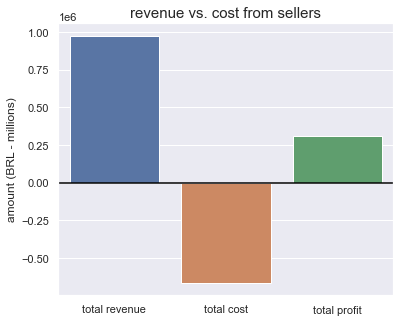

In [187]:
max_profit_id = sorted_sellers.profit_after_it_costs.idxmax()
max_profit_value = int(sorted_sellers.profit_after_it_costs.max())
total_profit = int(sorted_sellers.profit_after_it_costs.iloc[-1])
total_cost = total_profit - max_profit_value
pl_dict = {'total_revenue': max_profit_value, 'total_cost': total_cost, 'total_profit': total_profit}
pl_df = pd.DataFrame(pl_dict.values(), columns=['amount'], index=pl_dict)

plt.figure(figsize=(6, 5))
ax = sns.barplot(x=pl_df.index, y=pl_df.amount)
plt.title('revenue vs. cost from sellers', fontdict={'fontsize': 15})
plt.ylabel('amount (BRL - millions)')
plt.axhline(0, c='black')
ax.set_xticklabels(['total revenue', 'total cost', 'total profit']);

Notice the huge cost!  Our goal is to: 
- find which sellers are contributing the most to the cost
- identify criteria for removing sellers 

In [18]:
num_sellers = len(sorted_sellers)
num_profitable_sellers = len(sorted_sellers[sorted_sellers['profit'] > 0])
num_bad_sellers = num_sellers - num_profitable_sellers
pd.DataFrame()

- total number of sellers: 2967
- number of profitable sellers (left of orange dot): 2475
- number of unprofitable sellers (right of oragne dot): 492

## Which sellers should be removed? 🤔

use just one criteria:
- Total accumulated loss for Olist from that seller is -450 BRL or more 💰 

### Analyzing Sellers whose Cost > Revenue
**Revenue** 😎  
Olist gets 💲 from sellers due to receiving:
- 10% of sale price per order
- 80 BRL per month subscription fee

**Cost** 😢  
Olist loses 💲 from sellers due to:
- Bad customer reviews 👎
- IT costs 🖥

In [33]:
review_cost_dict = {'1 star': 100, '2 stars': 50, '3 stars': 40, '4 stars': 0, '5 stars': 0}
review_cost_df = pd.DataFrame(review_cost_dict.values(), 
             columns=['cost'],
             index=review_cost_dict.keys()
            )

\*NOTE* For this analysis, we make two assumptions:

- each poor review costs Olist the following:

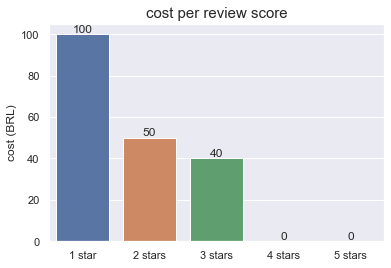

In [224]:
sns.set_theme()
plt.figure(figsize=(6,4))
ax = sns.barplot(x=review_cost_df.index, y=review_cost_df.cost)
ax.bar_label(ax.containers[0])
plt.title('cost per review score', fontdict={'fontsize': 15})
plt.ylabel('cost (BRL)');

- IT costs are proportional to the square root of the number of orders:

$ total\;IT\;costs = \sqrt{total\;number\;of\;orders} = 500,000\;BRL $

With these assumptions, we can calculate the profitability of each seller, and sort them from most profitable to least profitable

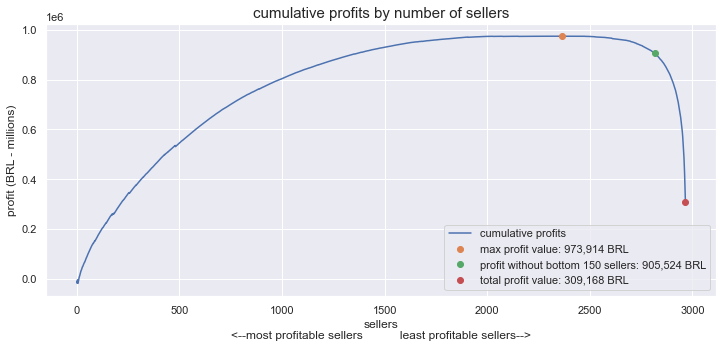

In [151]:
# plot cumulative it costs
plt.figure(figsize=(12,5))
sorted_sellers.profit_after_it_costs.plot(label='cumulative profits')
plt.title('cumulative profits by number of sellers', fontdict={'fontsize': 15})
plt.xlabel('sellers\n<--most profitable sellers           least profitable sellers-->')
plt.ylabel('profit (BRL - millions)')

# plot max profit value
max_profit_id = sorted_sellers.profit_after_it_costs.idxmax()
max_profit_value = int(sorted_sellers.profit_after_it_costs.max())
mpv = str(max_profit_value)[:3] + ',' + str(max_profit_value)[3:]
plt.plot(max_profit_id, max_profit_value, 'o', label=f'max profit value: {mpv} BRL')

# plot total profit value
total_profit_id = sorted_sellers.tail(1).index.item()
total_profit_value = int(sorted_sellers.profit_after_it_costs.iloc[-1])
tpv = str(total_profit_value)[:3] + ',' + str(total_profit_value)[3:]

# plot profit before bottom 100 sellers
profit_before_bottom_150_id = total_profit_id - 150
profit_before_bottom_150_value = int(sorted_sellers.profit_after_it_costs.iloc[profit_before_bottom_150_id])
pbb150 = str(profit_before_bottom_150_value)[:3] + ',' + str(profit_before_bottom_150_value)[3:]
plt.plot(profit_before_bottom_150_id, profit_before_bottom_150_value, 'o', label=f'profit without bottom 150 sellers: {pbb150} BRL')

plt.plot(total_profit_id, total_profit_value, 'o', label=f'total profit value: {tpv} BRL')

plt.legend();

In [133]:
total_cost = max_profit_value - total_profit_value
bottom_150_cost = profit_before_bottom_150_value - total_profit_value
print(bottom_150_cost / total_cost)
print(150 / len(sorted_sellers))

0.8971185986828052
0.05055611729019211


- All the sellers to the right of the orange dot are unprofitable sellers for Olist  
- The bottom 150 sellers (5% of all sellers) account for about 90% of lost profits 🤯
- The profit cutoff for the bottom 150 sellers is about -450 BRL 📉

Here's a look at the profit outliers

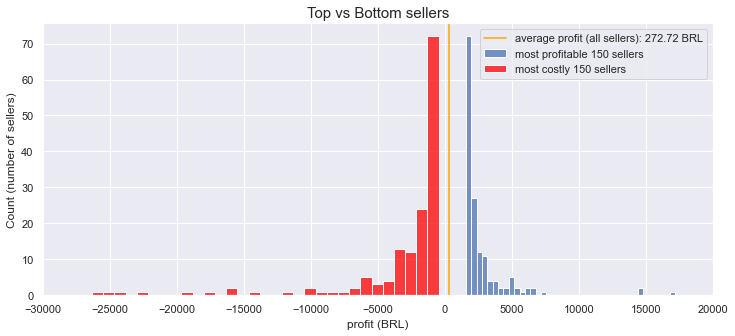

In [176]:
plt.figure(figsize=(12,5))
sns.histplot(sorted_sellers.profit.head(150), kde=False, label='most profitable 150 sellers')
sns.histplot(sorted_sellers.profit.tail(150), kde=False, color='red', label='most costly 150 sellers')
plt.axvline(sorted_sellers.profit.mean(), c='orange', label=f"average profit (all sellers): {sorted_sellers.profit.mean():.2f} BRL")
plt.title('Top vs Bottom sellers', fontdict={'fontsize': 15})
plt.xlabel('profit (BRL)')
plt.xticks(list(range(-30000, 20001, 5000)))
plt.ylabel('Count (number of sellers)')
plt.legend();

#### Shouldn't we cut ALL sellers with a net loss (i.e. whose costs for Olist exceed their revenue)? 🤔

🙅‍♂️ No!  We don't want to punish new sellers or low-order sellers, as this could negatively impact Olist's reputation and future sellers

### Affect on profit

In [160]:
profit_dict = {'all_sellers': [total_profit_value, round(sorted_sellers.profit.mean(), 2)], 
              'without_bottom_150': [profit_before_bottom_150_value, round(sorted_sellers.profit.iloc[:profit_before_bottom_150_id].mean(), 2)]}
profit_df = pd.DataFrame(profit_dict.values(), index=profit_dict, columns=['total_profit', 'avg_profit'])
profit_df

,total_profit,avg_profit
all_sellers,309168,272.72
without_bottom_150,905524,460.58


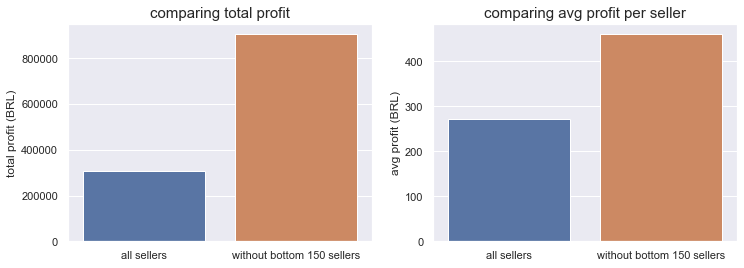

In [226]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.barplot(ax=ax[0], x=profit_df.index, y=profit_df.total_profit)
ax[0].set_title('comparing total profit', fontdict={'fontsize': 15})
ax[0].set_ylabel('total profit (BRL)')
ax[0].set_xticklabels(['all sellers', 'without bottom 150 sellers'])

sns.barplot(ax=ax[1], x=profit_df.index, y=profit_df.avg_profit)
ax[1].set_title('comparing avg profit per seller', fontdict={'fontsize': 15})
ax[1].set_ylabel('avg profit (BRL)')
ax[1].set_xticklabels(['all sellers', 'without bottom 150 sellers']);

In [175]:
profit_df.loc['without_bottom_150', 'total_profit'] - profit_df.loc['all_sellers', 'total_profit']

596356

**without the bottom 150 sellers, Olist could have saved nearly 600,000 BRL in costs associated with review scores and IT** 😲

By removing any seller whose net loss reaches -450 BRL, Olist can minimize the affect of those costs

By setting the limit at -450 BRL (and not 0 BRL), Olist can avoid unfairly removing the following sellers who may have a small net loss:
- new sellers
- low-order sellers
- well-established sellers with an insignificant net loss

## Analyzing the bottom sellers

The bottom 150 sellers have more one-star reviews and fewer five-star reviews than other sellers

In [218]:
avg_1star = sorted_sellers.share_of_one_stars.iloc[:-150].mean()
avg_1star_bottom150 = sorted_sellers.share_of_one_stars.iloc[-150:].mean()

avg_5star = sorted_sellers.share_of_five_stars.iloc[:-150].mean()
avg_5star_bottom150 = sorted_sellers.share_of_five_stars.iloc[-150:].mean()

stars_dict = {'without_bottom_150': [avg_1star, avg_5star], 
              'only_bottom_150': [avg_1star_bottom150, avg_5star_bottom150]}
stars_df = pd.DataFrame(stars_dict.values(), index=stars_dict.keys(), columns=['avg_share_of_one_stars', 'avg_share_of_five_stars'])
stars_df

,avg_share_of_one_stars,avg_share_of_five_stars
without_bottom_150,0.122062,0.595729
only_bottom_150,0.216409,0.469110


In [222]:
print(avg_1star_bottom150 - avg_1star)
print(avg_5star - avg_5star_bottom150)

0.09434736235319145
0.12661929069157896


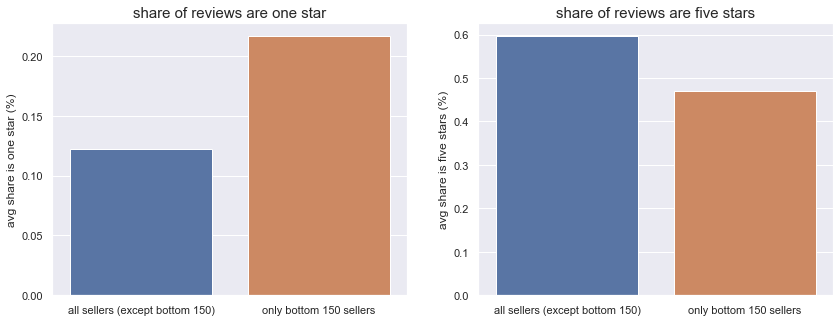

In [220]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

sns.barplot(ax=ax[0], x=stars_df.index, y=stars_df.avg_share_of_one_stars)
ax[0].set_title('share of reviews are one star', fontdict={'fontsize': 15})
ax[0].set_ylabel('avg share is one star (%)')
ax[0].set_xticklabels(['all sellers (except bottom 150)', 'only bottom 150 sellers'])

sns.barplot(ax=ax[1], x=stars_df.index, y=stars_df.avg_share_of_five_stars)
ax[1].set_title('share of reviews are five stars', fontdict={'fontsize': 15})
ax[1].set_ylabel('avg share is five stars (%)')
ax[1].set_xticklabels(['all sellers (except bottom 150)', 'only bottom 150 sellers']);

- Almost 22% of all reviews for the bottom 150 sellers are one star reviews - nearly 10% more than other sellers
- Almost 60% of all reviews for most sellers are five star reviews.  For the bottom 150 sellers, it's about 47%

### creating logistic regression models for one star and five star reviews


In [178]:
# data preparation
features = ['wait_time', 'expected_wait_time', 'delay_vs_expected', 'number_of_sellers', 'number_of_products', 'price', 'freight_value', 'distance_seller_customer']

def z_standardization(df, features):
    for feature in features:
        mean = df[feature].mean()
        std = df[feature].std()
        df[feature] = df[feature].apply(lambda x: (x - mean) / std)
    return df

z_orders = z_standardization(orders.copy(), features)

z_orders = z_orders[['dim_is_one_star', 'dim_is_five_star', 'review_score'] + features]
z_orders.head()

,dim_is_one_star,dim_is_five_star,review_score,wait_time,expected_wait_time,delay_vs_expected,number_of_sellers,number_of_products,price,freight_value,distance_seller_customer
0,0,0,4,-0.431192,-0.934806,-0.161781,-0.112544,-0.264595,-0.513802,-0.652038,-0.979475
1,0,0,4,0.134174,-0.524871,-0.161781,-0.112544,-0.264595,-0.086640,0.000467,0.429743
2,0,1,5,-0.329907,0.330878,-0.161781,-0.112544,-0.264595,0.111748,-0.164053,-0.145495
3,0,1,5,0.073540,0.279445,-0.161781,-0.112544,-0.264595,-0.441525,0.206815,2.054621
4,0,1,5,-1.019535,-1.326297,-0.161781,-0.112544,-0.264595,-0.562388,-0.652038,-0.959115


In [179]:
# VIF analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
vif_scores=[]
for i, f in enumerate(z_orders.columns):
    score = [f, vif(z_orders.values, i)]
    vif_scores.append(score)
    
pd.DataFrame(vif_scores, columns=['feature', 'vif_score']).sort_values('vif_score', ascending=False)

,feature,vif_score
1,dim_is_five_star,4.753470
2,review_score,4.731166
3,wait_time,3.206425
5,delay_vs_expected,2.466005
9,freight_value,1.679576
4,expected_wait_time,1.606817
10,distance_seller_customer,1.602219
7,number_of_products,1.383809
8,price,1.209150
0,dim_is_one_star,1.161443


In [181]:
# one_star model
l1_formula = "dim_is_one_star ~ {}".format(' + '.join(features))
logit_one = smf.logit(formula=l1_formula, data=z_orders).fit()
logit_one.summary()

Optimization terminated successfully.
         Current function value: 0.272741
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        dim_is_one_star   No. Observations:                95872
Model:                          Logit   Df Residuals:                    95863
Method:                           MLE   Df Model:                            8
Date:                Sun, 03 Apr 2022   Pseudo R-squ.:                  0.1474
Time:                        01:23:33   Log-Likelihood:                -26148.
converged:                       True   LL-Null:                       -30669.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.4842      0.013   -189.094      0.000      -2.510      -2.458
wait_time                    0.8353      0.020     42.415      0.000       0.797       0.874
expected_wait_time          -0.2048      0.017    -12.355      0.000      -0.237      -0.172
delay_vs_expected            0.1395      0.020      6.845      0.000       0.100       0.179
number_of_sellers            0.1863      0.008     23.517      0.000       0.171       0.202
number_of_products           0.2500      0.011     23.714      0.000       0.229       0.271
price                        0.0515      0.011      4.571      0.000       0.029       0.074
freight_value               -0.0128      0.012     -1.027      0.304      -0.037       0.012
distance_seller_customer    -0.1300      0.014     -9.103      0.000      -0.158      -0.102
============================================================================================
"""

In [182]:
# five_star model
l2_formula = "dim_is_five_star ~ {}".format(' + '.join(features))
logit_two = smf.logit(formula=l2_formula, data=z_orders).fit()
logit_two.summary()

Optimization terminated successfully.
         Current function value: 0.636466
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       dim_is_five_star   No. Observations:                95872
Model:                          Logit   Df Residuals:                    95863
Method:                           MLE   Df Model:                            8
Date:                Sun, 03 Apr 2022   Pseudo R-squ.:                 0.05859
Time:                        01:24:03   Log-Likelihood:                -61019.
converged:                       True   LL-Null:                       -64817.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.3416      0.007     47.749      0.000       0.328       0.356
wait_time                   -0.5642      0.013    -44.283      0.000      -0.589      -0.539
expected_wait_time           0.0736      0.009      8.323      0.000       0.056       0.091
delay_vs_expected           -0.3753      0.024    -15.529      0.000      -0.423      -0.328
number_of_sellers           -0.1455      0.008    -18.546      0.000      -0.161      -0.130
number_of_products          -0.1359      0.008    -16.240      0.000      -0.152      -0.120
price                        0.0204      0.008      2.676      0.007       0.005       0.035
freight_value                0.0009      0.009      0.101      0.919      -0.017       0.019
distance_seller_customer     0.0649      0.009      7.450      0.000       0.048       0.082
============================================================================================
"""

By creating logistic regression models for orders that received reviews of one star and five stars, we can see which features were most important for determining the score 🤓

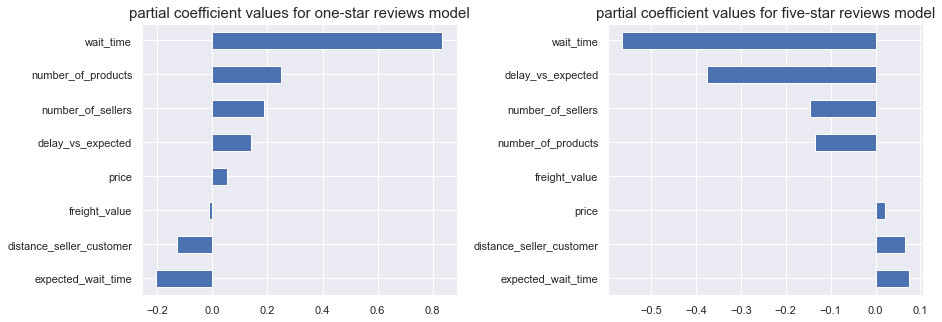

In [185]:
logit_one_df = pd.DataFrame(logit_one.params[1:].sort_values(), columns=['coef'])
logit_two_df = pd.DataFrame(logit_two.params[1:].sort_values(ascending=False), columns=['coef'])

fig, ax = plt.subplots(1, 2, figsize=(14,5))
logit_one_df.plot.barh(
    ax=ax[0],
    legend=False
)
ax[0].set_title('partial coefficient values for one-star reviews model', fontdict={'fontsize':15})


logit_two_df.plot.barh(
    ax=ax[1],
    legend=False
)
ax[1].set_title('partial coefficient values for five-star reviews model', fontdict={'fontsize':15})

plt.subplots_adjust(wspace=0.48);


- For one star reviews, the total wait time for delivery was much more influential than the other features at indicating a one-star review
- For five star reviews, delay of the expected wait time was quite influential in preventing a five-star review (in addition to the total wait time)

### So basically ...

The shorter the wait time for delivery, the less likely the order will receive a one-star review, thus preventing costs associated with poor reviews

In [199]:
avg_wait_time = sorted_sellers.wait_time.iloc[:-150].mean()
avg_wait_time_bottom150 = sorted_sellers.wait_time.iloc[-150:].mean()

avg_delay_to_carrier = sorted_sellers.delay_to_carrier.iloc[:-150].mean()
avg_delay_to_carrier_bottom150 = sorted_sellers.delay_to_carrier.iloc[-150:].mean()

wait_dict = {'without_bottom_150': [avg_wait_time, avg_delay_to_carrier], 
              'only_bottom_150': [avg_wait_time_bottom150, avg_delay_to_carrier_bottom150]}
wait_df = pd.DataFrame(wait_dict.values(), index=wait_dict.keys(), columns=['avg_wait_time', 'avg_delay_to_carrier'])
wait_df

,avg_wait_time,avg_delay_to_carrier
without_bottom_150,12.061956,0.384658
only_bottom_150,13.594143,0.404007


In [216]:
13.59-12.06

1.5299999999999994

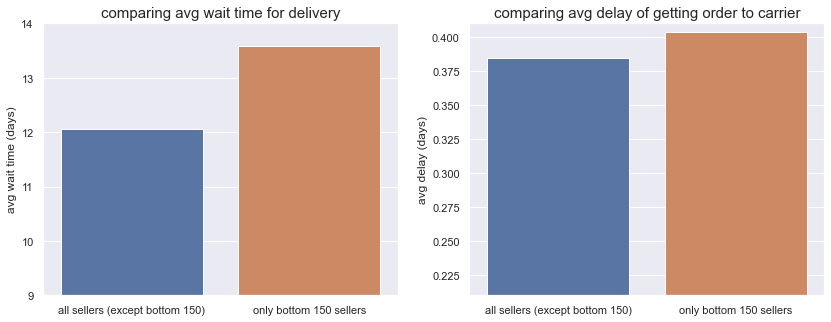

In [217]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

sns.barplot(ax=ax[0], x=wait_df.index, y=wait_df.avg_wait_time)
ax[0].set_title('comparing avg wait time for delivery', fontdict={'fontsize': 15})
ax[0].set_ylabel('avg wait time (days)')
ax[0].set_xticklabels(['all sellers (except bottom 150)', 'only bottom 150 sellers'])
ax[0].set_ylim([9, 14])

sns.barplot(ax=ax[1], x=wait_df.index, y=wait_df.avg_delay_to_carrier)
ax[1].set_title('comparing avg delay of getting order to carrier', fontdict={'fontsize': 15})
ax[1].set_ylabel('avg delay (days)')
ax[1].set_xticklabels(['all sellers (except bottom 150)', 'only bottom 150 sellers'])
ax[1].set_ylim([0.21, 0.41]);

- the average wait time for delivery from the bottom 150 sellers is 1.5 days slower than the rest of the sellers ⏱
- the average delay of getting the order to the carrier is 0.02 days (about half an hour) slower for the bottom 150 sellers 📦

## Recommendations

- Olist should remove sellers with a net loss of -450 BRL or more 📉

- Risky sellers should be identified as soon as possible using the following criteria:
    - their cost for Olist outweighs their revenue 💵
    - share of one star reviews is 20% or more ⭐️
    - average wait time for delivery is 13.5 days or more ⏳

- Once a risky seller is identified, they can receive support from Olist to help increase their share of 5 star reviews and decrease the wait time for delivery 🤗

# previous slideshow below

### Criteria two: 10+ months on olist

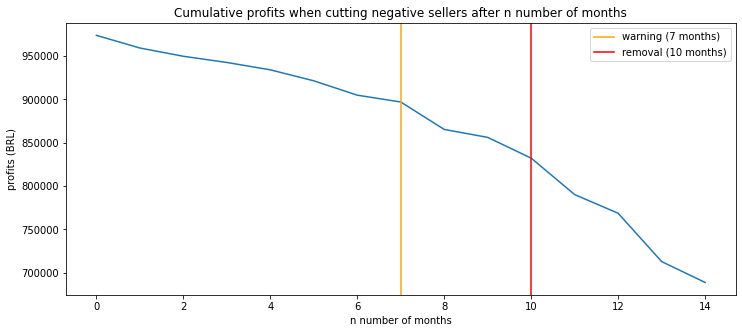

In [61]:
"""profits inculding all sellers before max profit point and all sellers after that point
who have been on olist under i number of months"""

profits = []
for m in range(0, 15):
    s2 = (sorted_sellers[(sorted_sellers.index < max_profit_id + 1) | (sorted_sellers.index > max_profit_id) & (sorted_sellers.months_on_olist < m)]).copy()
    s2['cum_profit'] = s2.profit.cumsum()
    s2['cum_it_costs'] = (s2.n_orders.cumsum() ** 0.5) * it_costs_coef
    s2['it_costs'] = s2.cum_it_costs - s2.cum_it_costs.shift(1, fill_value=0)
    s2['profit_after_it_costs'] = s2['cum_profit'] - s2['cum_it_costs']
    profits.append((m, s2.iloc[-1]['profit_after_it_costs']))

profits_df = pd.DataFrame(profits, columns=['months', 'profits'])

plt.figure(figsize=(12,5))
plt.plot(profits_df['months'], profits_df['profits'])
plt.title('Cumulative profits when cutting negative sellers after n number of months')
plt.xlabel('n number of months')
plt.ylabel('profits (BRL)')
plt.axvline(7, c='orange', label='warning (7 months)') # offer support to sellers whose total profits are negative
plt.axvline(10, c='red', label='removal (10 months)') # cut off sellers who still have negative total profits
plt.legend();

### Criteria three: 900+ orders

- many orders → high IT cost

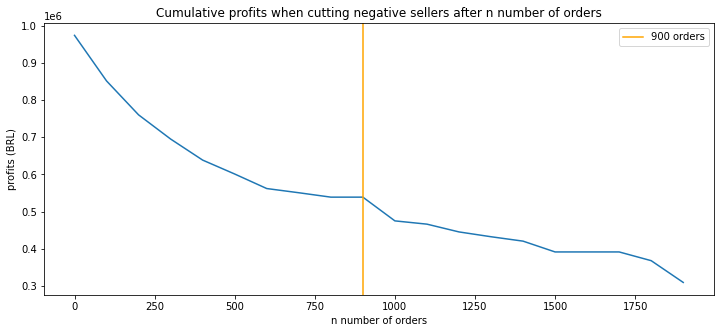

In [62]:
it_profits = []
for i in range(0, 2000, 100):
    s = (sorted_sellers[(sorted_sellers.index < max_profit_id + 1) | (sorted_sellers.index > max_profit_id) & (sorted_sellers.n_orders < i)]).copy()
    s['cum_profit'] = s.profit.cumsum()
    s['cum_it_costs'] = (s.n_orders.cumsum() ** 0.5) * it_costs_coef
    s['it_costs'] = s.cum_it_costs - s.cum_it_costs.shift(1, fill_value=0)
    s['profit_after_it_costs'] = s['cum_profit'] - s['cum_it_costs']
    it_profits.append((i, s.iloc[-1]['profit_after_it_costs']))
    
it_profits_df = pd.DataFrame(it_profits, columns=['num_orders', 'profits'])
plt.figure(figsize=(12,5))
plt.plot(it_profits_df['num_orders'], it_profits_df['profits'])
plt.title('Cumulative profits when cutting negative sellers after n number of orders')
plt.xlabel('n number of orders')
plt.ylabel('profits (BRL)')
plt.axvline(900, c='orange', label='900 orders') # offer support to sellers whose total profits are negative
plt.legend();

## How many sellers cut?

In [95]:
# num sellers
n_orders_cutoff = 900
months_cutoff = 10
final_df = sorted_sellers[(sorted_sellers.index < max_profit_id + 1) | (sorted_sellers.index > max_profit_id) & (sorted_sellers.n_orders < n_orders_cutoff) & (sorted_sellers.months_on_olist < months_cutoff)]
num_sellers_before = sorted_sellers.shape[0]
num_sellers_after = final_df.shape[0]
num_sellers_before - num_sellers_after

# avg profits
profit_after = final_df.profit.mean()
profit_before = sorted_sellers.profit.mean()

# avg it costs
it_after = final_df.it_cost.mean()
it_before = sorted_sellers.it_cost.mean()

compare_df = pd.DataFrame([[num_sellers_before, num_sellers_after], [profit_before, profit_after],[it_before, it_after]], columns=['before', 'after'], index=['num_sellers', 'avg_profit', 'avg_it_cost'])

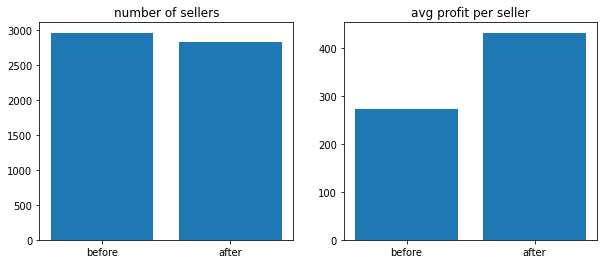

In [127]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
plt.setp([ax1, ax2], xticks=[1,2], xticklabels=['before', 'after'])
ax1.bar([1,2], [compare_df.iloc[0].before, compare_df.iloc[0].after])
ax2.bar([1,2], [compare_df.iloc[1].before, compare_df.iloc[1].after])
ax1.title.set_text('number of sellers')
ax2.title.set_text('avg profit per seller')

#### It's so good! 🤯 

## Q & A ✋